<a href="https://colab.research.google.com/github/sampriti/Computer_Vision_DL/blob/main/transfer_learning_in_blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mounting the dataset for training

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = "/content/gdrive/My Drive/caltech101/train"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importing all the required libraries

In [ ]:
import torchvision
from torchvision import datasets,models
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split
import torch.optim as optim
import matplotlib.pyplot as plt
#import sys
import os
import copy
import time
!pip install -q torchinfo
from torchinfo import summary

### Defining the data directory, model name, number of output classes, number of epochs, feature extracting option

In [ ]:
#set data directory
data_dir = "/content/drive/My Drive/caltech101/train"

# set model to alexnet
model_name='alexnet'

# Number of classes in the dataset
num_classes = 30

# # Batch size for training
# batch_size = 24

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

### Defining the device type, data preprocessing and prepare the train and validation dataset

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
normalize =  transforms.Normalize(mean=[0.485, 0.456, 0.406],                                     # These mean and std values were already defined for the dataset that was used
                                 std=[0.229, 0.224, 0.225])                                       # was used for training alexnet
resize = transforms . Resize ((224 , 224) )
rotation = transforms.RandomRotation(degrees = 90)
# Define the low-light augmentation transform
low_light_augmentation = transforms.ColorJitter(
    brightness=(0, 0.5)  # Adjust brightness between 0 and 0.5 (0.5 is half the original brightness)
)
preprocessor = transforms.Compose ([ resize , transforms . ToTensor () , normalize ,low_light_augmentation ])


dataset=torchvision.datasets.ImageFolder(root_path,preprocessor)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


cuda:0


### Creating a dataloader dictionary to access training dataset and validation dataset

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

dataloaders_dict = {
    'train': train_loader,
    'val': val_loader
}



### Defining the train function where we train using training dataset and also evaluate validation loss at every batch

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### Creating a function which freezes gradient calculations for all the layers except the last classfication layer

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
  print(feature_extracting)
  if feature_extracting:
      for param in model.parameters():
          param.requires_grad = False
          # print("parameters",param)

### Fetching the alexnet model from the server and displaying how it looks like

In [ ]:
model_ft = models.alexnet(pretrained=True)
summary(model_ft,col_names=["trainable"],row_settings=["var_names"])


Layer (type (var_name))                  Trainable
AlexNet (AlexNet)                        True
├─Sequential (features)                  True
│    └─Conv2d (0)                        True
│    └─ReLU (1)                          --
│    └─MaxPool2d (2)                     --
│    └─Conv2d (3)                        True
│    └─ReLU (4)                          --
│    └─MaxPool2d (5)                     --
│    └─Conv2d (6)                        True
│    └─ReLU (7)                          --
│    └─Conv2d (8)                        True
│    └─ReLU (9)                          --
│    └─Conv2d (10)                       True
│    └─ReLU (11)                         --
│    └─MaxPool2d (12)                    --
├─AdaptiveAvgPool2d (avgpool)            --
├─Sequential (classifier)                True
│    └─Dropout (0)                       --
│    └─Linear (1)                        True
│    └─ReLU (2)                          --
│    └─Dropout (3)                       --
│    └─

### The last layer is modified to classify only the number of layers in our dataset. The set parameter gradient function is called to freeze the layers and the model summary is printed to show that only last new layer is trainable

In [ ]:

model_ft = model_ft.to(device)
# print(feature_extract)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
summary(model_ft,col_names=["trainable"],row_settings=["var_names"])



True


Layer (type (var_name))                  Trainable
AlexNet (AlexNet)                        Partial
├─Sequential (features)                  False
│    └─Conv2d (0)                        False
│    └─ReLU (1)                          --
│    └─MaxPool2d (2)                     --
│    └─Conv2d (3)                        False
│    └─ReLU (4)                          --
│    └─MaxPool2d (5)                     --
│    └─Conv2d (6)                        False
│    └─ReLU (7)                          --
│    └─Conv2d (8)                        False
│    └─ReLU (9)                          --
│    └─Conv2d (10)                       False
│    └─ReLU (11)                         --
│    └─MaxPool2d (12)                    --
├─AdaptiveAvgPool2d (avgpool)            --
├─Sequential (classifier)                Partial
│    └─Dropout (0)                       --
│    └─Linear (1)                        False
│    └─ReLU (2)                          --
│    └─Dropout (3)                    

In [ ]:
# input_size = 224
# image_datasets = {x: dataset for x in ['train','val']}

# dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
# params_to_update = model_ft.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 1510
    Root location: /content/gdrive/My Drive/caltech101/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               ColorJitter(brightness=(0.0, 0.5), contrast=None, saturation=None, hue=None)
           )

In [ ]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fc2f0304250>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fc2f0535850>}

### Define the optimizer and the loss function to be used

In [ ]:

#Larger rate for the last layer
optimizer_ft = optim.SGD([{'params': model_ft.classifier[6].parameters(), 'lr':0.01}], lr=0.001, momentum=0.9)
# Setup the loss fnc
criterion = nn.CrossEntropyLoss()

### send the model to the device(cpu or gpu) we selected and call the train function

In [ ]:
# Train and evaluate
model_ft = model_ft.to(device)
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=100)
#PATH = '/content/gdrive/My Drive/caltech101.finetune_new.pth'
#torch.save(model_ft.state_dict(), PATH)


Epoch 0/99
----------
train Loss: 0.9697 Acc: 0.7839
val Loss: 1.6548 Acc: 0.7185

Epoch 1/99
----------
train Loss: 0.9384 Acc: 0.7972
val Loss: 2.0476 Acc: 0.7053

Epoch 2/99
----------
train Loss: 0.9738 Acc: 0.8096
val Loss: 1.4812 Acc: 0.7252

Epoch 3/99
----------
train Loss: 0.8294 Acc: 0.8063
val Loss: 1.6380 Acc: 0.6821

Epoch 4/99
----------
train Loss: 0.8906 Acc: 0.8096
val Loss: 1.3114 Acc: 0.7119

Epoch 5/99
----------
train Loss: 0.8865 Acc: 0.7939
val Loss: 1.8910 Acc: 0.6523

Epoch 6/99
----------
train Loss: 0.9161 Acc: 0.7997
val Loss: 1.8482 Acc: 0.6987

Epoch 7/99
----------
train Loss: 1.0059 Acc: 0.7889
val Loss: 1.4788 Acc: 0.7152

Epoch 8/99
----------
train Loss: 0.9340 Acc: 0.8013
val Loss: 1.5228 Acc: 0.7252

Epoch 9/99
----------
train Loss: 0.8361 Acc: 0.8079
val Loss: 1.6948 Acc: 0.6954

Epoch 10/99
----------
train Loss: 0.8684 Acc: 0.8121
val Loss: 1.5851 Acc: 0.7185

Epoch 11/99
----------
train Loss: 0.9425 Acc: 0.8030
val Loss: 1.5379 Acc: 0.7351

Ep

### Load the test data and calculate the accuracy

In [ ]:
test_dir = "/content/gdrive/My Drive/caltech101/test"
testset=torchvision.datasets.ImageFolder(test_dir,preprocessor)
testloader=torch . utils . data . DataLoader( testset , batch_size=4 , shuffle=True)
test_labels = testloader.dataset.targets
# print(test_labels)
correct = 0
total = 0
confusion_matrix = torch.zeros(30, 30)
labels_list=[]
predicts_list=[]
all_predicted=[]
t=0
p=0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        #for t, p in zip(labels.view(-1), predicted.view(-1)):     # line are for Confusion matrix
        #        confusion_matrix[t.long(), p.long()] += 1         # line are for Confusion matrix
        #labels_list.append(labels)
        #predicts_list.append(predicted)
        labels_list+=labels.cpu().numpy().tolist()
        #print(outputs)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()
        all_predicted += predicted.cpu().numpy().tolist()
        # print(len(all_predicted))
        # print("total",total)

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
#print(labels_list)
#print(all_predicted)

Accuracy of the network on the test images: 72 %


### Compute and plot the confusion matrix

450 450
Confusion matrix


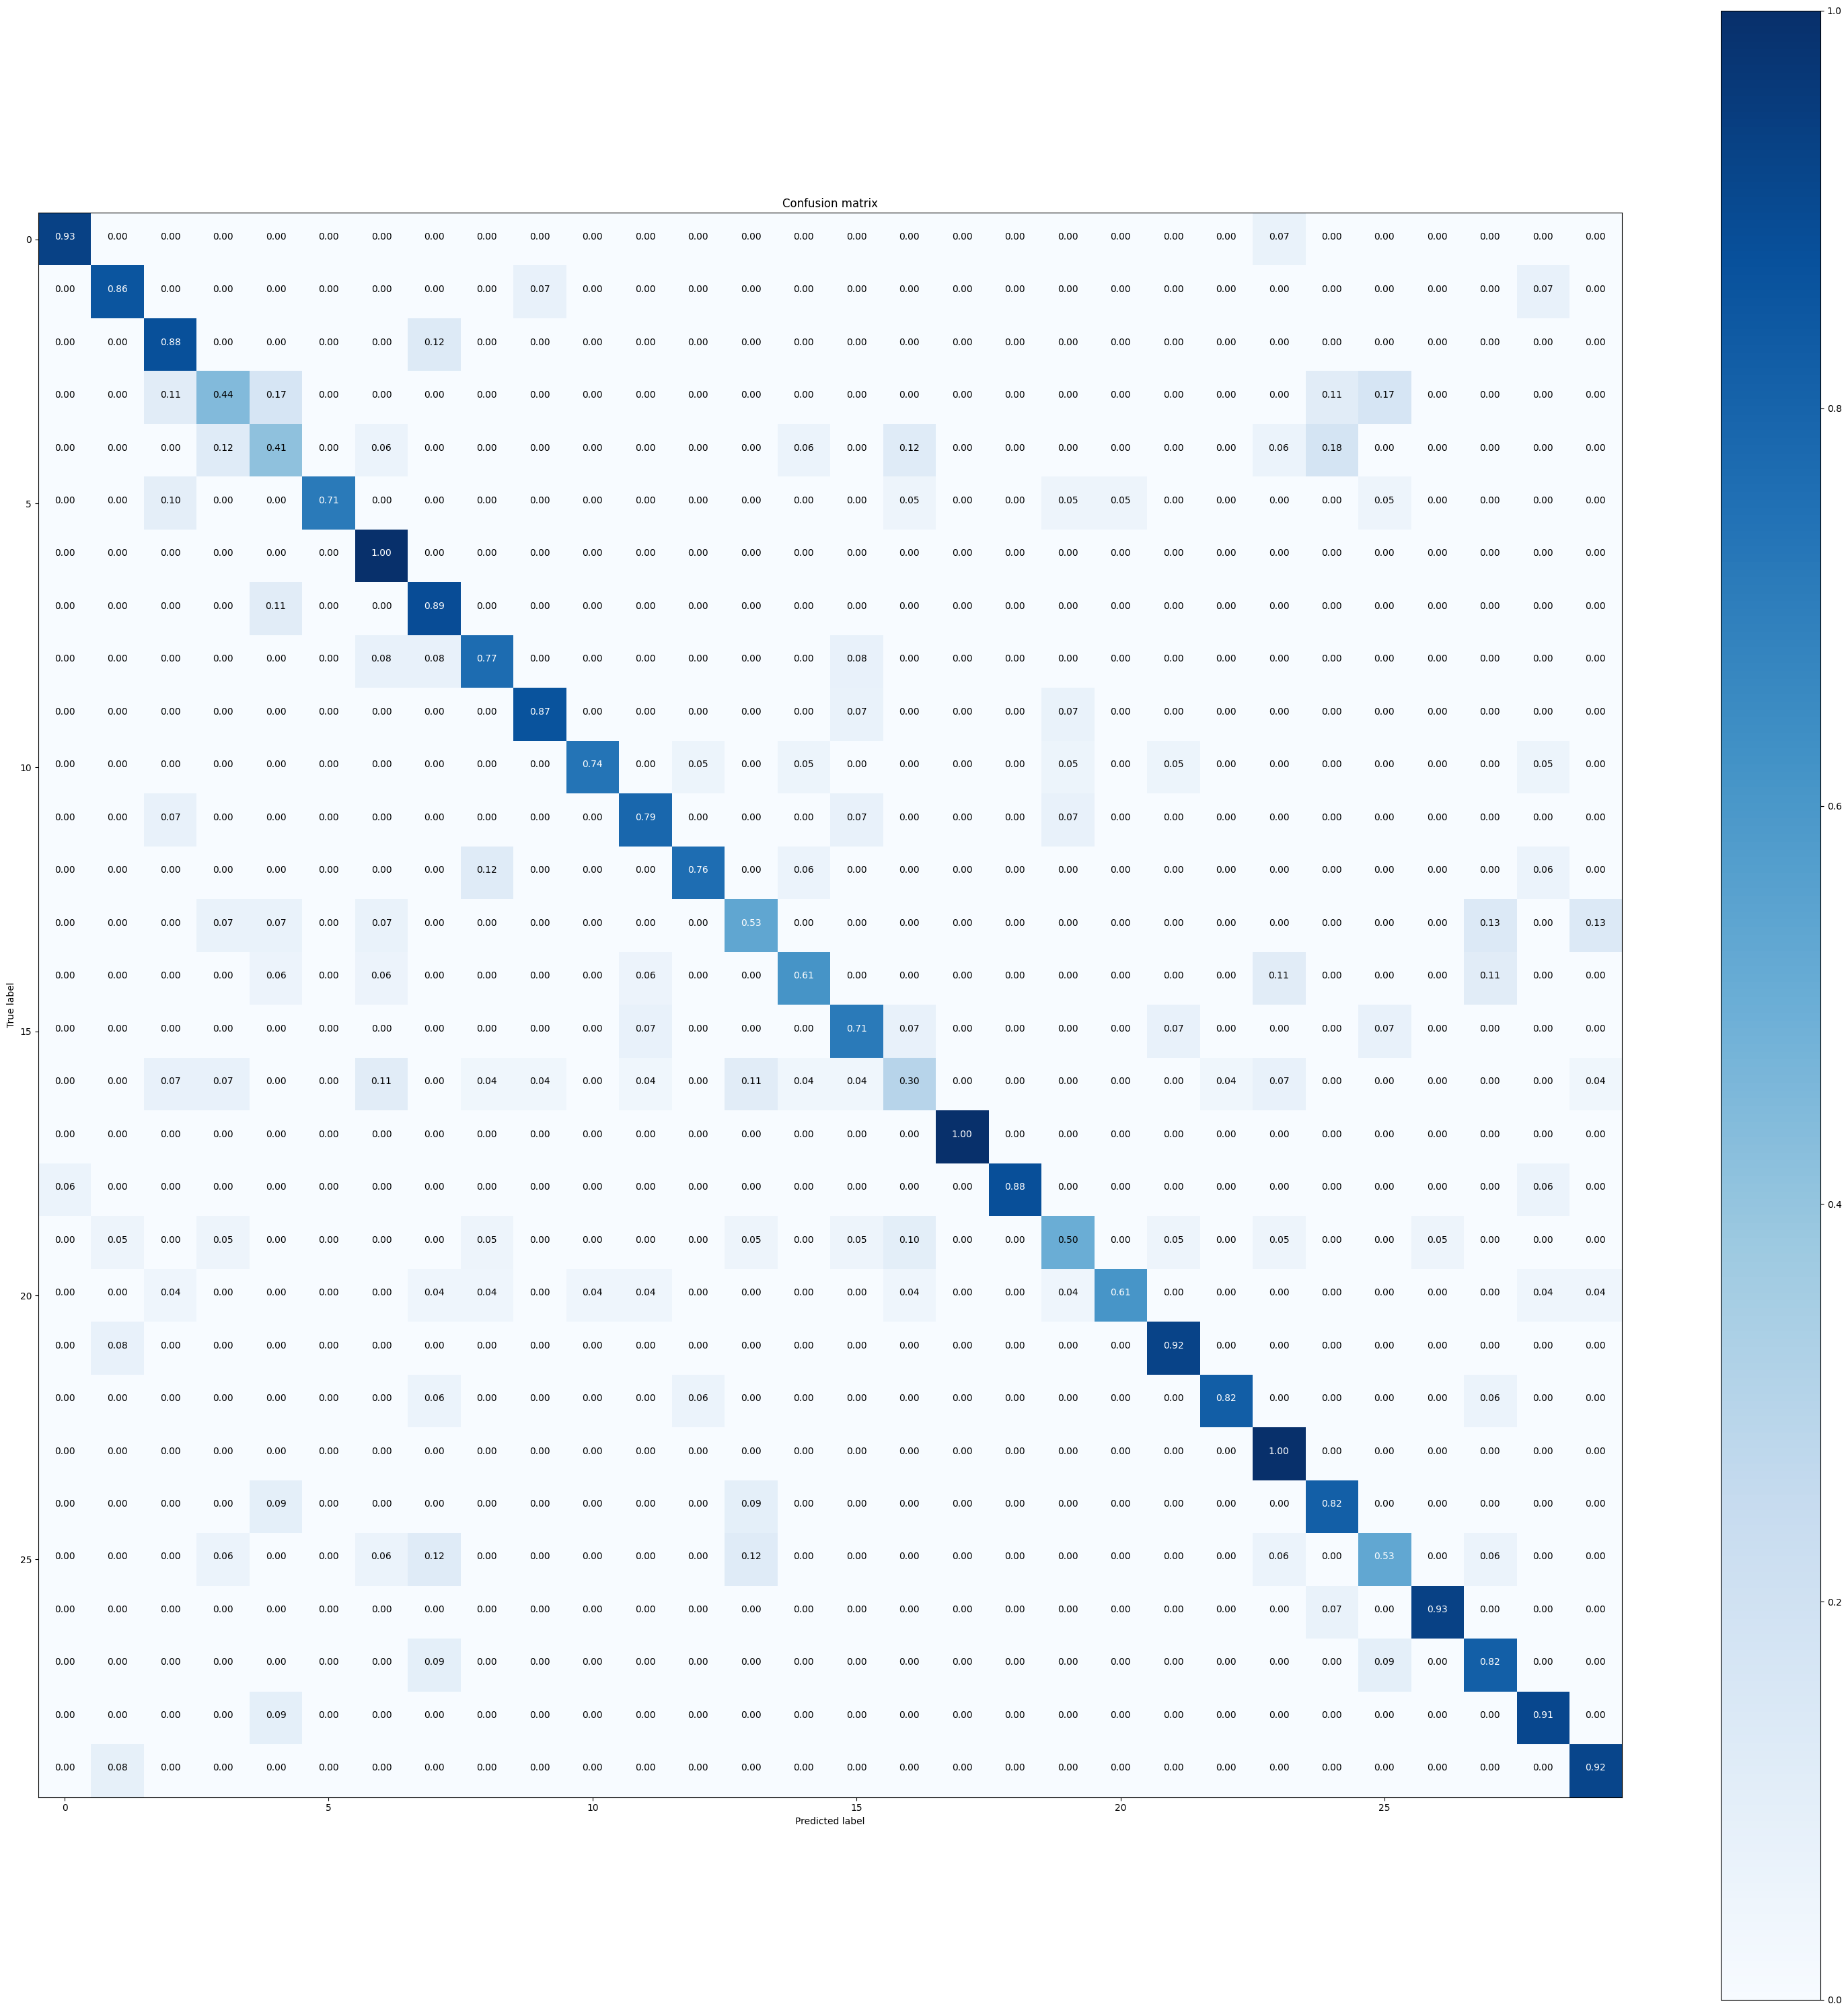

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(pred_class, actual_class,
                          title='Confusion matrix',
                          size=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Code from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(actual_class, pred_class)



    cmap = plt.cm.Blues
    # cmap = plt.cm
    cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
    cm = np.nan_to_num(cm)

    if cm is not None:
        cm = cm[0:size, 0:size]

    print('Confusion matrix')
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#testloader=torch . utils . data . DataLoader( testset , batch_size=4 , shuffle=True)
#net1 = FullNet()
#net1.fit(trainloader)
pred_labels =all_predicted# p.long()#net1.predict(testloader)
plt.figure(figsize=(30,30))

print(len(labels_list),len(pred_labels))

test_labels = labels_list#t.long()#testloader.dataset.targets
plot_confusion_matrix(test_labels, pred_labels,size=len(pred_labels))
#plot_confusion_matrix(confusion_matrix,size=len(pred_labels))
